# Data analysis on Taiwanese credit card holders' payment defaults.

# Libraries used

In [1]:
import io
import numpy as np
import pandas as pd
import requests
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time


# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier

# SVC classifier
from sklearn.svm import SVC #, LinearSVC

# grid search and random search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Functions used

In [2]:
# function to check balance of data
def check_balance(df):
    print('\nThe number of 0s (non-defaulters) in the dataframe is', list(df['target']).count(0),'out of',len(df),'samples.')
    percentage = round(100*list(df['target']).count(0)/len(df),2) 
    if (48 < percentage and percentage < 52):
        print('That is',percentage,'%, therefore data is balanced.')
        res = True
    else:
        print('That is',percentage,'%, therefore data is unbalanced.')   
        res = False
    return res    
    
# function to balance data    
def data_balance(dataframe):
    if len(dataframe[dataframe['target']==1])<=len(dataframe[dataframe['target']==0]):
        balanced_dataframe = dataframe[dataframe['target']==1]
        balanced_dataframe = balanced_dataframe.append(dataframe[dataframe['target']==0].sample(len(dataframe[dataframe['target']==1])))
    if len(dataframe[dataframe['target']==0]) < len(dataframe[dataframe['target']==1]):
        balanced_dataframe = dataframe[dataframe['target']==0]
        balanced_dataframe = balanced_dataframe.append(dataframe[dataframe['target']==1].sample(len(dataframe[dataframe['target']==0])))
    return balanced_dataframe   

def normalize_column(df,label):
    mean = np.mean(list(df[str(label)]))
    std = np.std(list(df[str(label)]))
    normalised_column = (list(df[str(label)])-mean)/std
    return normalised_column             


 # Downloading excell file

In [3]:
# Downloading the excell file from the url
data_url='https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
data_stream=requests.get(data_url).content

# Reading the excell file
df=pd.read_excel(data_stream, header=1, index_col=0) 

# Renaming the output
df = df.rename(columns={'default payment next month': 'target'})

# Manipulation of data

In [4]:
# dropping samples with 'EDUCATION' attribute > 4
df = df.drop(df.index[df['EDUCATION'] > 4])

# dropping samples with 'PAY_0' attribute < -1
df = df.drop(df.index[df['PAY_0']< -1])

# summation of monthly bill statements minus monthly payments 
df ['BILL-PAYMENT_TOTAL'] = df[df.columns[11:17]].sum(axis=1)-df[df.columns[17:23]].sum(axis=1)

# I tried to log this column but i got inf errors, i discaded the zeros, but still I got errors so I quit with the "log"ing
#df = df.drop(df.index[df['BILL-PAYMENT_TOTAL']== 0])
#df ['log(BILL-PAYMENT_TOTAL)'] = np.log(df ['BILL-PAYMENT_TOTAL'])

In [5]:
print('The following is a sample of the dataframe\n')
df.loc[1]

The following is a sample of the dataframe



LIMIT_BAL             20000
SEX                       2
EDUCATION                 2
MARRIAGE                  1
AGE                      24
PAY_0                     2
PAY_2                     2
PAY_3                    -1
PAY_4                    -1
PAY_5                    -2
PAY_6                    -2
BILL_AMT1              3913
BILL_AMT2              3102
BILL_AMT3               689
BILL_AMT4                 0
BILL_AMT5                 0
BILL_AMT6                 0
PAY_AMT1                  0
PAY_AMT2                689
PAY_AMT3                  0
PAY_AMT4                  0
PAY_AMT5                  0
PAY_AMT6                  0
target                    1
BILL-PAYMENT_TOTAL     7015
Name: 1, dtype: int64

# Balancing the data

In [6]:
check_balance(df)  
balanced_data = data_balance(df)
check_balance(balanced_data)
print('\nnow we have a better perspective and balanced accuracy = accuracy')
data = balanced_data


The number of 0s (non-defaulters) in the dataframe is 20705 out of 26951 samples.
That is 76.82 %, therefore data is unbalanced.

The number of 0s (non-defaulters) in the dataframe is 6246 out of 12492 samples.
That is 50.0 %, therefore data is balanced.

now we have a better perspective and balanced accuracy = accuracy


Splitting of data

# Input features

In [7]:
input_features = data.columns[:-2]
input_features2 = ['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1', 'BILL_AMT2']

# Train Test Split

In [8]:
percentage_of_samples_used_for_testing = 1/3
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
train, test = train_test_split(data, test_size = percentage_of_samples_used_for_testing)

# Random Forest Classifier was the best one so far

In [9]:
# rf classifiers attribute
rf_model = RandomForestClassifier()
rf_model.fit(train[input_features], train['target'])
rf_predictions = rf_model.predict(test[input_features])
print('\nRandom Forest')
print(' * Accuracy          :',round(accuracy_score(test['target'],rf_predictions),2))

from sklearn.model_selection import cross_val_predict
K = 5
rf_cv_predictions = cross_val_predict(rf_model, data[input_features], data['target'], cv = K)

print('\n\nCross Validation Random Forest, K=',K)
print('  * Accuracy          :', round(accuracy_score(data['target'],rf_cv_predictions),2))


Random Forest
 * Accuracy          : 0.71


Cross Validation Random Forest, K= 5
  * Accuracy          : 0.7


The most recent payment delay status is the feature with the higher importance. Second place belongs to the most recent bill statement followed by the Limit Balance, Age and then the rest of the features. Even though these 4 first importances have been calculated based on math by a machine, they make perfect sense in the human world.


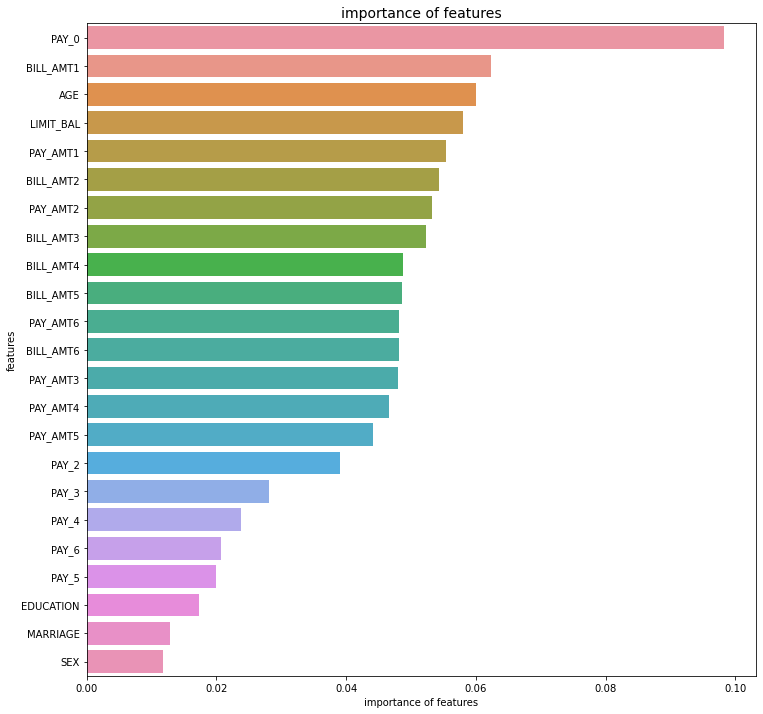

In [10]:
feature_importances = rf_model.feature_importances_
# creating a dataframe
dataframe = pd.DataFrame({'features': input_features, 'importance of features': feature_importances });
# sorting by descending feature importance
dataframe = dataframe.sort_values(by='importance of features', ascending=False);
plt.figure(figsize = (12,12))
sns.barplot(x='importance of features',y='features',data = dataframe);
plt.title('importance of features',fontsize=14);

print('The most recent payment delay status is the feature with the higher importance. Second place belongs\
 to the most recent bill statement followed by the Limit Balance, Age and then the rest of the features.\
 Even though these 4 first importances have been calculated based on math by a machine, they make perfect sense in the human world.')

In [11]:
important_features = list(dataframe.features[:10])
print(important_features)

['PAY_0', 'BILL_AMT1', 'AGE', 'LIMIT_BAL', 'PAY_AMT1', 'BILL_AMT2', 'PAY_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5']


# Continue your assignment on Predicting Credit Card Defaults in Taiwan in 2005. This time, however, you know a little bit about optimisation, Pandas' data processing, and about SVMs so use your new superpowers! We need to answer some questions such as: Is any SVM classifier feasible to identify defaulting customers? Can any SVC compete with any SVM? Do we need to apply GridSearch or RandomSearch for the parameters of each SVM kernel? (use only the polynomial and the RBF ones - we can leave the linear and sigmoid ones aside) Is the best SVM classifier found by you better than your previous best classifier? And better than RandomForest? Reason your steps and conclusions, like in the first assignment. And for extra marks: Can you plot the most relevant information about some of the SVCs/SVMs you analysed? You can select pairs of the most relevant input features and plot them like they do in here or in here Even more, you can select three of the most important features and plot them in 3D. Also examples here. Note: To plot stuff, maybe you will need take a sample of 100 or 200 records from the 30k records of the original dataset. Submission: The same Jupyter Notebook as before, or a new one with just this assignment. Whatever you prefer!

# Normalising all important data

In [12]:
for i in range( len(important_features) ):
    data[important_features[i]+'_NORMALISED'] = normalize_column(data,important_features[i])
important_features_normalised = data.columns[-10:]

In [13]:
#data['target_NORMALISED'] = normalize_column(data,'target')
#data['target_NORMALISED']
important_features_normalised

Index(['PAY_0_NORMALISED', 'BILL_AMT1_NORMALISED', 'AGE_NORMALISED',
       'LIMIT_BAL_NORMALISED', 'PAY_AMT1_NORMALISED', 'BILL_AMT2_NORMALISED',
       'PAY_AMT2_NORMALISED', 'BILL_AMT3_NORMALISED', 'BILL_AMT4_NORMALISED',
       'BILL_AMT5_NORMALISED'],
      dtype='object')

# SVC

In [14]:
#input_features = important_features
#input_features = data.columns[:-2]
input_features = important_features_normalised
sv_classifier = SVC(
    C=1.0,
    kernel='rbf',
    degree=3,
    gamma='auto', #1/len(input_features),
    #coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=None,

)
train, test = train_test_split(data, test_size = 1/3)
sv_classifier.fit(train[input_features],train['target'])
svc_predictions = sv_classifier.predict(test[input_features])

print('\n\nSVC ')
print('  * Accuracy          :', round(accuracy_score(test['target'],svc_predictions),2))




SVC 
  * Accuracy          : 0.69


# Grid Search SVC

In [15]:
input_features = important_features_normalised

# building grid

cs = np.linspace(1,5,4)
kernels = ('poly','rbf')
gammas = np.linspace(0.005,1,5)
parameter_grid = {'C': cs,
                  'kernel': kernels,
                  'gamma': gammas}

# samples 
sample_data = data.sample(1000,random_state=1)
res = str(check_balance(sample_data));
if res == 'False' :
    print('\n...balancing_data...')
    sample_data = data_balance(sample_data);
    check_balance(sample_data);  
print('\n')

example_data = sample_data

train, test = train_test_split(example_data, test_size = 0.9)

# initiating grid search
classifier = SVC()
SVC_grid_search = GridSearchCV ( SVC() ,
    param_grid = parameter_grid,  
    #n_jobs=-1,  
    cv=10,        
    verbose=2,
    refit = True,
    scoring='accuracy' 
)
#print('Sample size =',len(sample_data),'\n')

#sampling
#train, test = train_test_split(data, test_size = 1/3)

# fitting 
#SVC_grid_search.fit(train[input_features], train['target'])
SVC_grid_search.fit(example_data[input_features], example_data['target'])


#scores = list(SVC_grid_search.cv_results_['mean_test_score'])
#maximum_score = max(scores)
#index_of_maximum_score = scores.index(maximum_score)

# I am planning to use those two later to create a parameter space (also could have used SVC_grid_search.param_grid)
#c_dimension = list(SVC_grid_search.cv_results_['param_C'])
#kernel_dimension = list(SVC_grid_search.cv_results_['param_kernel'])
#gamma_dimension = list(SVC_grid_search.cv_results_['param_gamma'])

#optimal_cs = c_dimension[index_of_maximum_score]
#optimal_kernel = kernel_dimension[index_of_maximum_score]
#optimal_gamma = gamma_dimension[index_of_maximum_score]

#print(f'best accuracy ({str(SVC_grid_search.scoring)}) : {maximum_score} for C={optimal_cs}, {optimal_kernel}-kernel and gamma = {optimal_gamma}' )

scores = list(SVC_grid_search.cv_results_['mean_test_score'])
maximum_score = max(scores)
index_of_maximum_score = scores.index(maximum_score)
predictions = SVC_grid_search.predict(data[input_features])


best_c = SVC_grid_search.best_params_['C']
best_kernel = SVC_grid_search.best_params_['kernel']
best_gamma = SVC_grid_search.best_params_['gamma']
print(f'best accuracy ({str(SVC_grid_search.scoring)}) : {round(maximum_score,3)} for C = {best_c}, {best_kernel}-kernel and gamma = {best_gamma}' )
#accuracy_score(test['target'],predictions)





The number of 0s (non-defaulters) in the dataframe is 493 out of 1000 samples.
That is 49.3 %, therefore data is balanced.


Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END ....................C=1.0, gamma=0.005, kernel=poly; total time=   0.1s
[CV] END ....................C=1.0, gamma=0.005, kernel=poly; total time=   0.1s
[CV] END ....................C=1.0, gamma=0.005, kernel=poly; total time=   0.1s
[CV] END ....................C=1.0, gamma=0.005, kernel=poly; total time=   0.0s
[CV] END ....................C=1.0, gamma=0.005, kernel=poly; total time=   0.0s
[CV] END ....................C=1.0, gamma=0.005, kernel=poly; total time=   0.1s
[CV] END ....................C=1.0, gamma=0.005, kernel=poly; total time=   0.1s
[CV] END ....................C=1.0, gamma=0.005, kernel=poly; total time=   0.1s
[CV] END ....................C=1.0, gamma=0.005, kernel=poly; total time=   0.1s
[CV] END ....................C=1.0, gamma=0.005, kernel=poly; total time=   0.1s
[

In [16]:
SVC_grid_search.cv_results_['mean_test_score']

array([0.508, 0.687, 0.66 , 0.688, 0.656, 0.684, 0.667, 0.675, 0.665,
       0.672, 0.509, 0.687, 0.649, 0.682, 0.66 , 0.68 , 0.665, 0.673,
       0.672, 0.666, 0.51 , 0.688, 0.66 , 0.679, 0.664, 0.677, 0.669,
       0.674, 0.683, 0.66 , 0.51 , 0.688, 0.66 , 0.676, 0.665, 0.68 ,
       0.668, 0.673, 0.682, 0.655])

# Random search SVC

In [17]:
from sklearn.model_selection import RandomizedSearchCV

cs = np.linspace(1,5,4)
kernels = ('poly','rbf')
gammas = np.linspace(0.005,1,5)
parameter_grid = {'C': cs,
                  'kernel': kernels,
                  'gamma': gammas}


SVC_random_search = RandomizedSearchCV ( SVC(),
    param_distributions = parameter_grid,  
    #n_jobs=-1,  
    n_iter=5,                                    
    cv=5,        
    verbose=2,    
    scoring='accuracy' 
)

#sample_data = data

res = str(check_balance(sample_data));

if res == 'False' :
    print('balancing_data...')
    sample_data = data_balance(sample_data);
    check_balance(sample_data);  
    
print('\n')
SVC_random_search.fit(sample_data[input_features], sample_data['target'])
scores = list(SVC_random_search.cv_results_['mean_test_score'])
maximum_score = max(scores)
#index_of_maximum_score = scores.index(maximum_score)

best_c = SVC_random_search.best_params_['C']
best_kernel = SVC_random_search.best_params_['kernel']
best_gamma = SVC_random_search.best_params_['gamma']
print(f'\nbest accuracy ({str(SVC_random_search.scoring)}) : {round(maximum_score,3)} for C = {best_c}, {best_kernel}-kernel and gamma = {best_gamma}' )

   


The number of 0s (non-defaulters) in the dataframe is 493 out of 1000 samples.
That is 49.3 %, therefore data is balanced.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .......C=3.6666666666666665, gamma=1.0, kernel=poly; total time=   7.2s
[CV] END .......C=3.6666666666666665, gamma=1.0, kernel=poly; total time=   6.8s
[CV] END .......C=3.6666666666666665, gamma=1.0, kernel=poly; total time=   8.7s
[CV] END .......C=3.6666666666666665, gamma=1.0, kernel=poly; total time=   7.7s
[CV] END .......C=3.6666666666666665, gamma=1.0, kernel=poly; total time=  14.9s
[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=   0.1s
[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=   0.1s
[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=   0.1s
[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=   0.1s
[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=   0.1s
[CV]

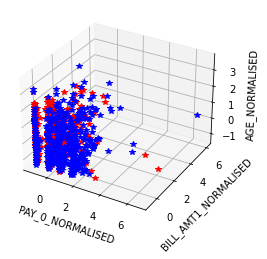

In [18]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line

plot_points = data.sample(1000)

defaulters = plot_points[plot_points['target']==0]
non_defaulters = plot_points[plot_points['target']==1] 

xline_d = defaulters[str(important_features_normalised[0])]
yline_d = defaulters[str(important_features_normalised[1])]
zline_d= defaulters[str(important_features_normalised[2])]

xline_nd = non_defaulters[str(important_features_normalised[0])]
yline_nd = non_defaulters[str(important_features_normalised[1])]
zline_nd = non_defaulters[str(important_features_normalised[2])]
 
ax.plot3D(xline_d, yline_d, zline_d, 'r*');
ax.plot3D(xline_nd, yline_nd, zline_nd, 'b*');

ax.set_xlabel(str(important_features_normalised[0]));
ax.set_ylabel(str(important_features_normalised[1]));
ax.set_zlabel(str(important_features_normalised[2]));

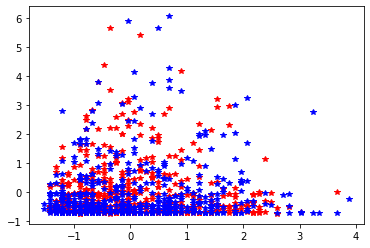

In [19]:
plt.plot(zline_d, yline_d,  'r*')
plt.plot(zline_nd, yline_nd, 'b*')

# printing 2-d scatterplots with pairs of the first four most relevant features

sample size : 50
2d scatter plots for pairs between the first four most important features


      PAY_0 vs BILL_AMT1


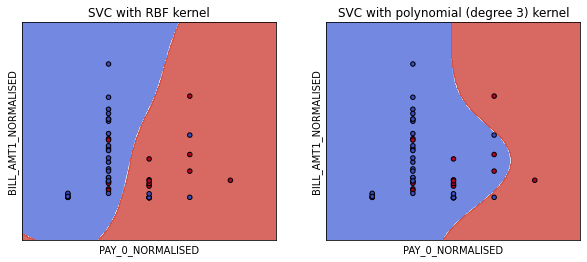



      PAY_0 vs AGE


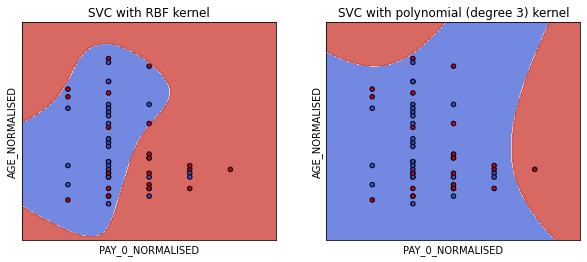



      BILL_AMT1 vs AGE


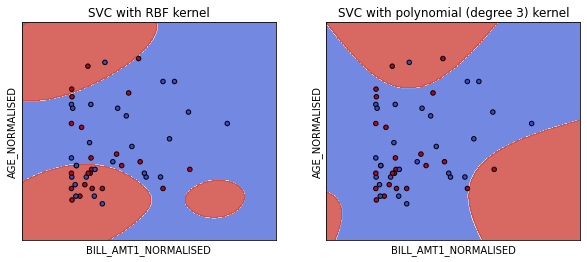



      PAY_0 vs LIMIT_BAL


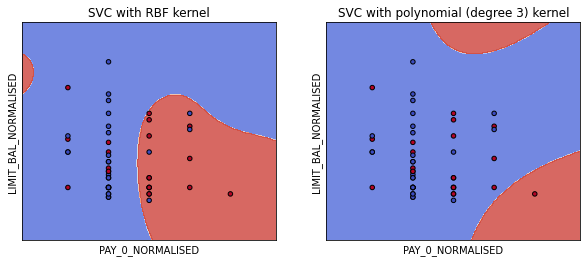



      BILL_AMT1 vs LIMIT_BAL


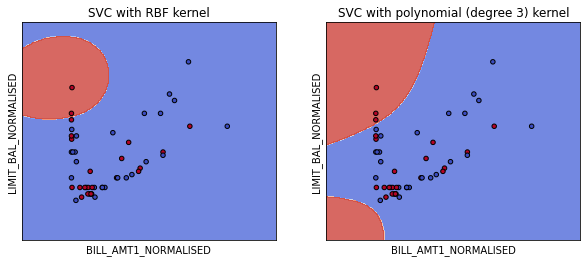



      AGE vs LIMIT_BAL


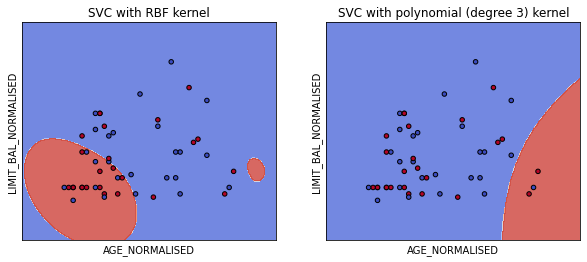

In [20]:
from sklearn import svm

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


train, test = train_test_split(data, test_size = int(len(data)-50)/len(data))

print('sample size :', len(train)) 
print('2d scatter plots for pairs between the first four most important features')

# combinations of j,i with no repeating pairs
for j in range(4):
    for i in range(j):
            #print(j,i)
            print('\n\n     ',important_features_normalised[i][:-11],'vs',important_features_normalised[j][:-11])
        
            
            # we create an instance of SVM and fit out data. We do not scale our
            # data since we want to plot the support vectors
            C = 1.0  # SVM regularization parameter
            models = (svm.SVC(kernel='rbf', gamma='auto', C=C), svm.SVC(kernel='poly', gamma='auto', degree=3, C=C))
            features = [important_features_normalised[i],important_features_normalised[j]]
            models = (clf.fit(np.array(train[features]), train['target']) for clf in models)

            # titles for the plots

            titles = ('SVC with RBF kernel', 'SVC with polynomial (degree 3) kernel')

            # Set-up 2x2 grid for plotting.

            fig, sub = plt.subplots(1, 2,figsize=(10,4))
            plt.subplots_adjust(hspace=0.2)

            feature0 = np.array(train[important_features_normalised[i]])
            feature1 = np.array(train[important_features_normalised[j]])

            xx, yy = make_meshgrid(feature0, feature1)

        

            for clf, title, ax in zip(models, titles, sub.flatten()):
                plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8 )
                ax.scatter(feature0, feature1, c=train['target'], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
                ax.set_xlim(xx.min(), xx.max())
                ax.set_ylim(yy.min(), yy.max())
                ax.set_xlabel(important_features_normalised[i])
                ax.set_ylabel(important_features_normalised[j])
                ax.set_xticks(())
                ax.set_yticks(())
                ax.set_title(title)
            plt.show()




                 PAY_0 vs BILL_AMT1 vs PAY_0


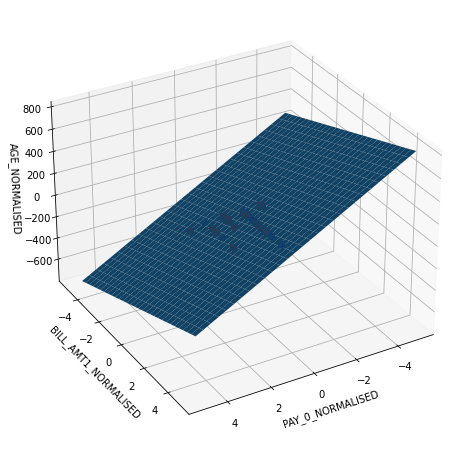



                 PAY_0 vs BILL_AMT1 vs PAY_0


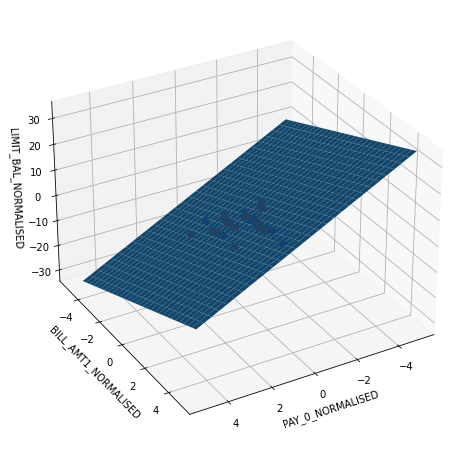



                 PAY_0 vs AGE vs PAY_0


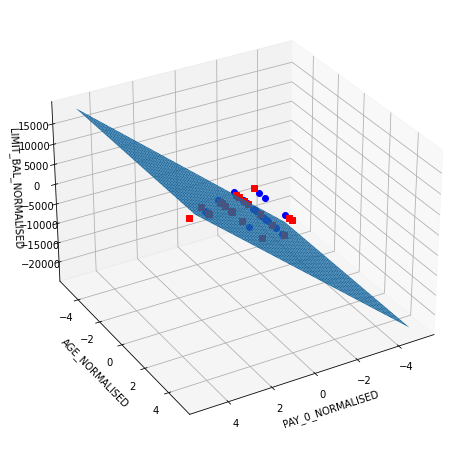



                 BILL_AMT1 vs AGE vs BILL_AMT1


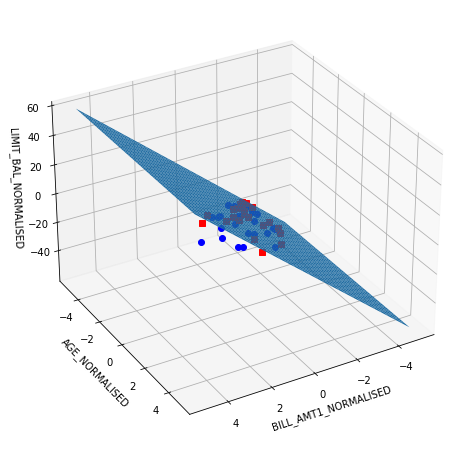

In [21]:
from mpl_toolkits.mplot3d import Axes3D
i=0
j=1
k=2
for i in range(4):
    for j in range(i):
        for k in range(j):
            #print(k,j,i)
            print('\n\n    \
            ',important_features_normalised[k][:-11],'vs',important_features_normalised[j][:-11],'vs',
                 important_features_normalised[k][:-11])
            feature0 = train[important_features_normalised[k]]
            feature1 = train[important_features_normalised[j]]
            feature2 = train[important_features_normalised[i]]

            X = np.array([feature0,feature1,feature2]).T  # we only take the first three features.
            Y = train['target']

            #make it binary classification problem
            #X = X[np.logical_or(Y==0,Y==1)]
            #Y = Y[np.logical_or(Y==0,Y==1)]

            model = SVC(kernel='linear',gamma='auto')
            clf = model.fit(X, Y)

            # The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
            # Solve for w3 (z)
            z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

            tmp = np.linspace(-5,5,30)
            x,y = np.meshgrid(tmp,tmp)

            fig = plt.figure(figsize=(8,8))
            ax1  = fig.add_subplot(111, projection='3d')
            ax1.plot3D(X[Y==0,0], X[Y==0,1], X[Y==0,2],'ob')
            ax1.plot3D(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr')
            ax1.plot_surface(x, y, z(x,y))
            ax1.set_xlabel(important_features_normalised[k])
            ax1.set_ylabel(important_features_normalised[j])
            ax1.set_zlabel(important_features_normalised[i])
            ax1.view_init(30, 60)
            plt.show()